Import Dependencies

In [4]:
import cv2  #To import OpenCV in our Notebook
import os # Make it easier to work with different directories with different file paths
import random #Optional
import numpy as np
import matplotlib.pyplot as plt


In [5]:
# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

 #Model (input=[input_img, verification_img], output = [1,0])  

Create Folder Structures

In [12]:
#Setup Path
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

#Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

Collect Positives and Anchors

In [362]:
# Webcam data - Anchor - model Encoding

# Uncompress Tar GZ Labelled Faces in Wild DataSet
!tar -xf lfw.tgz

In [ ]:
#Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        Ex_Path = os.path.join('lfw',directory, file)
        New_Path = os.path.join(NEG_PATH, file)
        os.replace(Ex_Path, New_Path)

Collect Positive and Anchor Classes

In [6]:
# Import uuid library to generate unique image names
import uuid

os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\4749bfef-5197-11ef-a596-f854f620658a.jpg'

In [8]:
#Connection to webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    #Cut down frame to 250x250
    frame = frame[130:380, 200:450, :]
    #Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())) 
        cv2.imwrite(imgname, frame)

    #Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())) 
        cv2.imwrite(imgname, frame)

        
    #Show img back to screen
    cv2.imshow('Image collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()



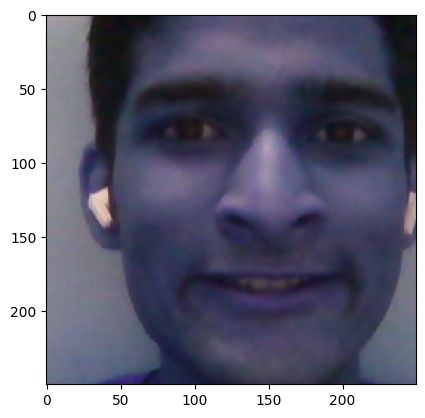

In [11]:
plt.imshow(frame) 

Load and Preporcess Images

In [12]:
# TO get the images in a specific directory

anchor = tf.data.Dataset.list_files(ANC_PATH+'\\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\\*.jpg').take(300)

In [13]:
ANC_PATH+'\\*.jpg'

'data\\anchor\\*.jpg'

In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
dir_test.next()

b'data\\anchor\\972efa38-4e5b-11ef-8f16-f854f620658a.jpg'

In [16]:
# Preprocessing - Scale and Resize
# Going to use dataset.map(preprocess) to apply for every sample
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img
    


In [17]:
#plt.imshow(img)
#kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
#Kernel = 1.35*kernel/255.0
#sharp = cv2.filter2D(IMG, -1, Kernel)
#sh = cv2.cvtColor(sharp, cv2.COLOR_BGR2RGB)
#plt.imshow(sharp)

In [18]:
#Create Labelled Dataset
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
samples = data.as_numpy_iterator()

In [20]:
eg = samples.next()

In [21]:
eg

(b'data\\anchor\\9a1f045a-4e5b-11ef-8770-f854f620658a.jpg',
 b'data\\positive\\b1f6a8f3-4e5b-11ef-9457-f854f620658a.jpg',
 1.0)

In [22]:
# Build and Train Partition

def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [23]:
k = preprocess_twin(*eg)

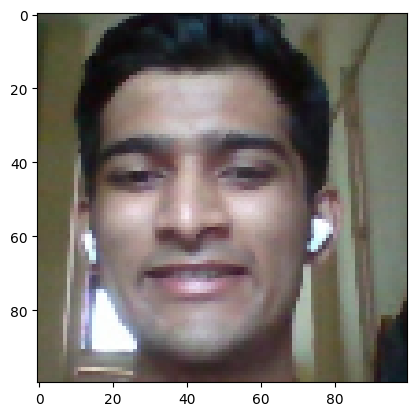

In [24]:
plt.imshow(k[1])

In [25]:
# Build a dataloader
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [26]:
 samples = data.as_numpy_iterator()
len(samples.next())

3

In [27]:
a = samples.next()

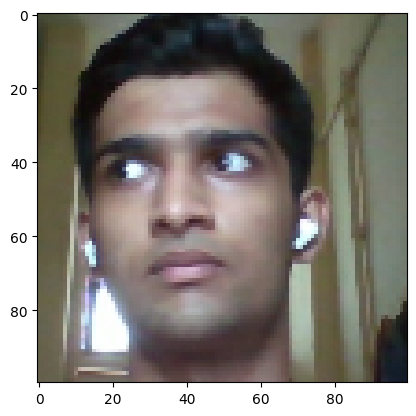

In [28]:
plt.imshow(a[0])

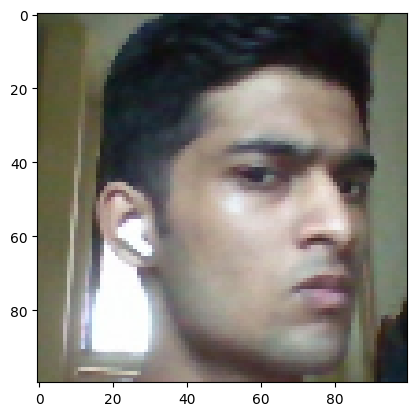

In [29]:
plt.imshow(a[1])

In [30]:
a[2]

1.0

In [31]:
# Training Partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [32]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()

In [33]:
#Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.7))
test_data = train_data.batch(16)
test_data = train_data.prefetch(8)

Model Engineering

In [34]:
#Build embedding layer
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [35]:
embedding = make_embedding()

In [36]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        
        input_tensor = input_embedding[0]  # Assuming you need the first tensor in the list
        validation_tensor = validation_embedding[0]  # Assuming you need the first tensor in the list
    
        # Perform the subtraction
        return tf.math.abs(input_tensor - validation_tensor)

    def compute_output_shape(self, input_shape):
        return input_shape[0]


In [38]:
l1 = L1Dist()

In [44]:
def make_siamese_model(): 
    # Anchor image input in the network
    input_image = tf.keras.layers.Input(name='input_img', shape=(100, 100, 3))
    
    # Validation image in the network 
    validation_image = tf.keras.layers.Input(name='validation_img', shape=(100, 100, 3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = tf.keras.layers.Dense(1, activation='sigmoid')(distances)
    
    return tf.keras.Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [45]:
siamese_model = make_siamese_model()

In [46]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (None, 4096)              │               0 │ embedding[2][0],           │
│                               │                           │                 │ embedding[3][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# TRAIN MODEL

In [47]:
# LOSS function 
binary_cross_loss = tf.losses.BinaryCrossentropy()

# optimizer

opt = tf.keras.optimizers.Adam(1e-4) # .0001

In [48]:
# establish checkpoints 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [49]:
EPOCHS = 50 

In [50]:
# # basic flow 
# prediction 
# loss 
# gradient 
# new weights 

In [51]:
test_batch = train_data.as_numpy_iterator()

In [52]:
batch_1 = test_batch.next()

In [53]:
len(batch_1)
batch_1[0]
len(batch_1[0])
batch_1[2]


array([0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
      dtype=float32)

In [54]:
#X = batch[:2]
#X
#y = batch[:2]
#y

NameError: name 'batch' is not defined

In [55]:
# compiles a function into a callable tensorflow graph 
@tf.function
def train_step(batch):
    # tf.Gradient allows us to record operation for automatic differentiation 
    with tf.GradientTape() as tape : 
        # get anchor and positive /negative image 
        X = batch[:2]
        # get label 
        y = batch[:2]

        # forward pass 
        yhat = siamese_model(X , training= True)
        if isinstance(y, tuple):
            y = y[0]  # Extract the tensor from the tuple if needed
        if isinstance(yhat, tuple):
            yhat = yhat[0]  # Extract the tensor from the tuple if needed
        # loss
        loss = binary_cross_loss(y , yhat)
    print(loss)
        # calculating gradients 
    grad = tape.gradient(loss , siamese_model.trainable_variables)
        # calculate updated weights and apply to siamese model 
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
        
        
    return loss 
def train_step(batch):
    X = batch[:2]  # Assuming X is properly extracted
    y = batch[2]   # Assuming y is the third element in the batch
    yhat = siamese_model(X, training=True)

    # Ensure y and yhat are tensors
    if isinstance(y, tuple):
        y = y[0]  # Extract the tensor from the tuple if needed
    if isinstance(yhat, tuple):
        yhat = yhat[0]  # Extract the tensor from the tuple if needed

    loss = binary_cross_loss(y, yhat)
    print(loss)

    # Assuming there's more code to update gradients, optimizer, etc.


In [56]:
def train(data, EPOCHS):
    #loop through the epochs 
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

# loop through each batch

    for idx , batch in enumerate(data):
        # run train step here 
        train_step(batch)
        progbar.update(idx+1)

    # save checkpoints
    if epoch % 10 == 0 :
        checkpoint.save(file_prefix=checkpoint_prefix)
        
        
        

In [57]:
train(train_data, EPOCHS)
# HERE to also print the loss defined above we need eager execution 



 Epoch 1/50

 Epoch 2/50

 Epoch 3/50

 Epoch 4/50

 Epoch 5/50

 Epoch 6/50

 Epoch 7/50

 Epoch 8/50

 Epoch 9/50

 Epoch 10/50

 Epoch 11/50

 Epoch 12/50

 Epoch 13/50

 Epoch 14/50

 Epoch 15/50

 Epoch 16/50

 Epoch 17/50

 Epoch 18/50

 Epoch 19/50

 Epoch 20/50

 Epoch 21/50

 Epoch 22/50

 Epoch 23/50

 Epoch 24/50

 Epoch 25/50

 Epoch 26/50

 Epoch 27/50

 Epoch 28/50

 Epoch 29/50

 Epoch 30/50

 Epoch 31/50

 Epoch 32/50

 Epoch 33/50

 Epoch 34/50

 Epoch 35/50

 Epoch 36/50

 Epoch 37/50

 Epoch 38/50

 Epoch 39/50

 Epoch 40/50

 Epoch 41/50

 Epoch 42/50

 Epoch 43/50

 Epoch 44/50

 Epoch 45/50

 Epoch 46/50

 Epoch 47/50

 Epoch 48/50

 Epoch 49/50

 Epoch 50/50
tf.Tensor(0.6933219, shape=(), dtype=float32)
 1/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/steptf.Tensor(0.6934214, shape=(), dtype=float32)
 2/27 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/steptf.Tensor(0.69284785, shape=(), dtype=float32)
 3/27 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/steptf.Tensor(0.6934632, shape=(), dtype=float32)
 4/27 ━━━━

In [58]:
# evaluate models 
# import metrics 

# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

# get a batch of test data 
test_input , test_val ,y_true = test_data.as_numpy_iterator().next()

In [59]:
test_var = test_data.as_numpy_iterator().next()

In [60]:
len(test_var[1])
test_var[1]

array([[[[2.68872559e-01, 3.00245106e-01, 2.10049018e-01],
         [2.67647058e-01, 2.99019605e-01, 2.05637261e-01],
         [2.66911775e-01, 2.98284322e-01, 2.07843140e-01],
         ...,
         [3.52941185e-01, 4.13725495e-01, 3.10539216e-01],
         [3.52941185e-01, 4.07843143e-01, 3.09068620e-01],
         [3.69607836e-01, 4.20588225e-01, 3.17156851e-01]],

        [[2.62745112e-01, 2.89460778e-01, 2.13725492e-01],
         [2.62009799e-01, 2.88725495e-01, 2.12990195e-01],
         [2.62990206e-01, 2.89705873e-01, 2.21323535e-01],
         ...,
         [3.69607836e-01, 4.26470578e-01, 3.13725501e-01],
         [3.62009794e-01, 4.14460778e-01, 3.03921580e-01],
         [3.68627459e-01, 4.16666657e-01, 3.06372553e-01]],

        [[2.44607836e-01, 2.60294110e-01, 2.01470584e-01],
         [2.44117647e-01, 2.59803921e-01, 2.00980395e-01],
         [2.64215678e-01, 2.81372547e-01, 2.23284319e-01],
         ...,
         [3.76225501e-01, 4.18382347e-01, 3.22303921e-01],
         [

In [61]:
test_val 
test_input 
y_true 


array([0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

In [62]:
# make prediction 
y_hat = siamese_model.predict([test_input , test_val])
y_hat


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0.50154364],
       [0.50062644],
       [0.5001637 ],
       [0.49984133],
       [0.50009096],
       [0.5005279 ],
       [0.500134  ],
       [0.50056875],
       [0.49993828],
       [0.5009316 ],
       [0.5009322 ],
       [0.50015867],
       [0.4999841 ],
       [0.5006107 ],
       [0.5007201 ],
       [0.500548  ]], dtype=float32)

In [63]:
# post processing 
[1 if prediction >0.5 else 0 for prediction in y_hat ] 


[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]

In [64]:
# res =[]

# for prediction in y_hat:
#     if prediction >0.5:
#         res.append(1)
#     else:
#         res.append(0)

# can also be done like this 

        
        

In [65]:
y_true

array([0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

In [67]:
# creating a metric object 
# m = Recall()
# calculating the recall value 
# m = update_state(y_true , y_hat)
# return recall result 
# m.result().numpy()


In [68]:
# plotting the results 


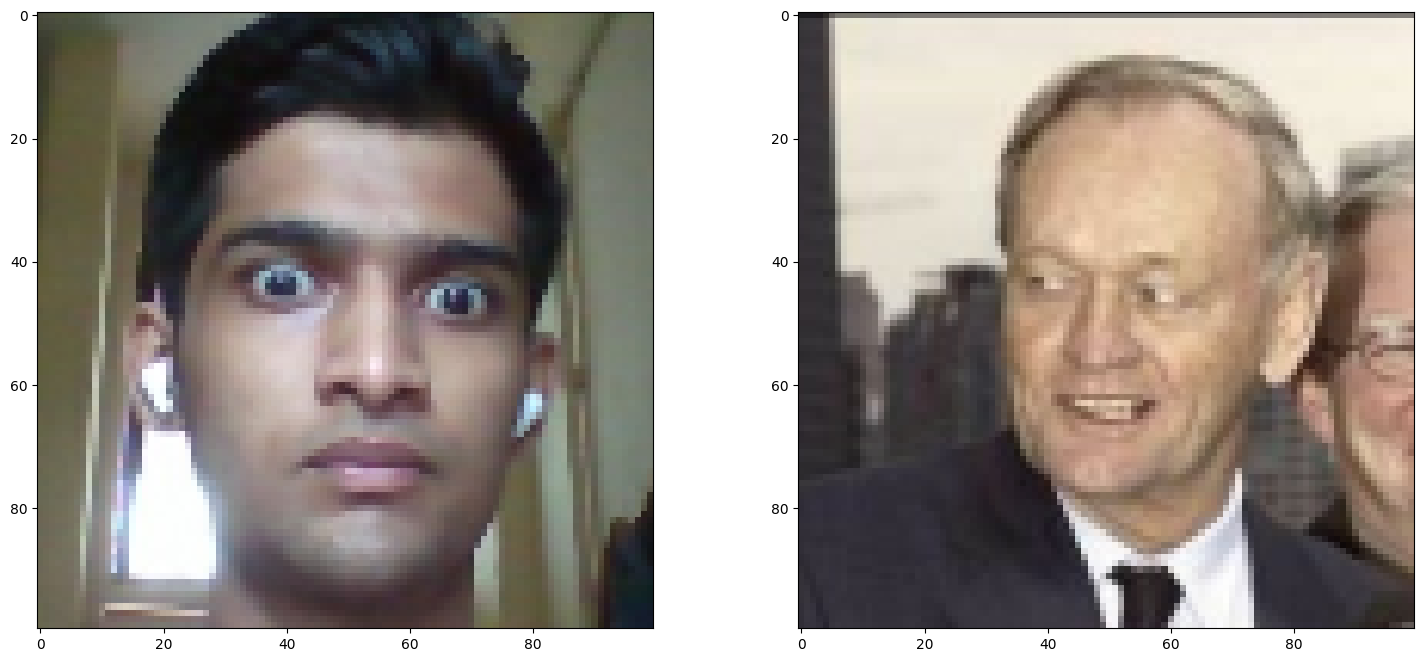

In [69]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

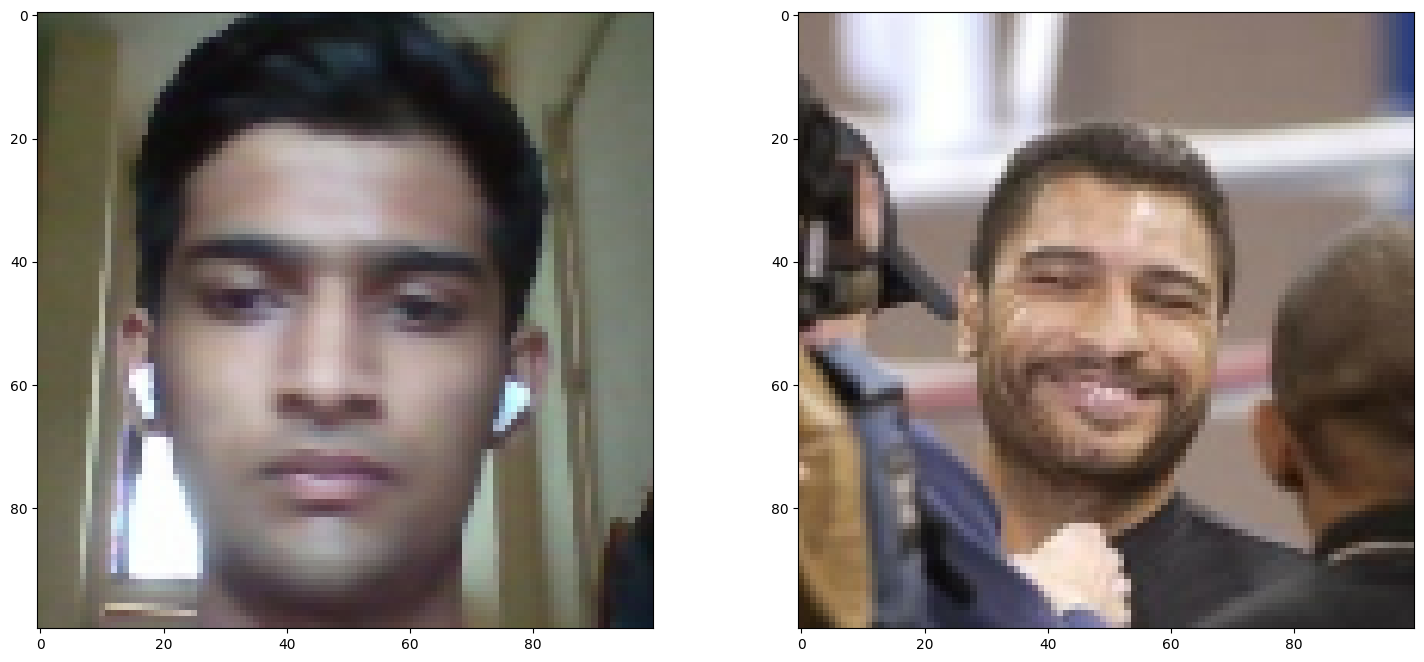

In [70]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[7])
plt.subplot(1,2,2)
plt.imshow(test_val[7])
plt.show()

In [71]:
# save the model 

In [72]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [73]:
L1Dist

__main__.L1Dist

In [74]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [75]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0.50154364],
       [0.50062644],
       [0.5001637 ],
       [0.49984133],
       [0.50009096],
       [0.5005279 ],
       [0.500134  ],
       [0.50056875],
       [0.49993828],
       [0.5009316 ],
       [0.5009322 ],
       [0.50015867],
       [0.4999841 ],
       [0.5006107 ],
       [0.5007201 ],
       [0.500548  ]], dtype=float32)

In [76]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)